In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time

% matplotlib inline

<matplotlib.colorbar.Colorbar instance at 0x106dbb170>

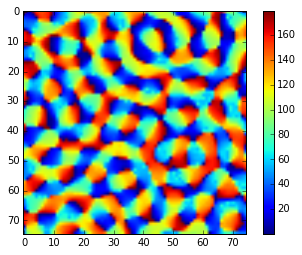

In [2]:
# Load orientation map from Bryan's code:

data = scipy.io.loadmat('orientation-map.mat')
OP_map = data['map']
plt.imshow(OP_map)
plt.colorbar()

In [3]:
# define functions:

def angle_diff(x,y):
    return np.abs(np.mod(x-y+90, 180) - 90)

def G(x, sigma):
    g = np.exp(-x**2 / 2. / sigma**2)
    return g

def get_weights(diff_pos, diff_angle, K_b, J_ab, sigma_ab, sigma_ori):
    p_ab = K_b * G(diff_pos, sigma_ab) * G(diff_angle, sigma_ori) # connection probability
    C_ab = np.zeros(p_ab.shape)
    C_ab[np.random.rand(p_ab.shape[0], p_ab.shape[1]) < p_ab] = 1 # binary connections
    W_ab = J_ab + .25*J_ab*np.random.randn(p_ab.shape[0], p_ab.shape[1])
    W_ab = W_ab * C_ab
    W_ab = np.fmax(0, W_ab)
    
    W_sum = np.sum(W_ab,1)
    avg_c = np.mean( np.sum(C_ab, 1) )
    
    print "Mean connections: ", avg_c
    
    for i in range(len(W_sum)):
#         print "%d of %d" % (i, len(W_sum))
        if W_sum[i] != 0:
            scale = J_ab * avg_c / W_sum[i]
            W_ab[i,:] = W_ab[i,:] * scale
    
    return W_ab

In [4]:
def run_simulation( dt, steps, c, h, n_E, n_I, k, tau_ex, tau_in, init_conds=np.zeros((75**2, 2))):
    
    I_E = np.zeros((N_pairs**2, steps+1))
    I_I = np.zeros((N_pairs**2, steps+1))
    r_E = np.zeros((N_pairs**2, steps+1))
    r_I = np.zeros((N_pairs**2, steps+1))

    r_E[:,0] = init_conds[:,0]
    r_I[:,0] = init_conds[:,1]
    
    for i in range(1,steps):
    #     print "timestep %d of %d" % (i,steps)
        I_E[:,i+1] = c*h.flatten(1) + np.sum(W_EE * r_E[:,i], 0) + np.sum(W_EI * r_I[:,i], 0)
        I_I[:,i+1] = c*h.flatten(1) + np.sum(W_IE * r_E[:,i], 0) + np.sum(W_II * r_I[:,i], 0)

        rss_E = k*np.fmax(0, I_E[:,i])**n_E # steady-state rate
        rss_I = k*np.fmax(0, I_I[:,i])**n_I
        r_E[:,i+1] = r_E[:,i] + dt * (1/tau_ex) * (-r_E[:,i] + rss_E)
        r_I[:,i+1] = r_I[:,i] + dt * (1/tau_in) * (-r_I[:,i] + rss_I)
        
    return [r_E, r_I, I_E, I_I]

In [5]:
N_pairs = 75
f_size = 16. # field side size, degrees
Dx = f_size/N_pairs
pos = (np.arange(75)+1) * Dx

posx = np.tile(pos, (N_pairs, 1))
posy = posx.T

K_E = 0.1
K_I = 0.5
J_EE = 0.1
J_IE = 0.38
J_EI = 0.059
J_II = 0.096
tau_ex = np.random.normal(.02, .05*.02, N_pairs**2)
tau_in = np.random.normal(.01, .05*.01, N_pairs**2)
k = np.random.normal(0.012, .05*.012, N_pairs**2)
n_E = np.random.normal(2.0, .05*2.0, N_pairs**2)
n_I = np.random.normal(2.2, .05*2.2, N_pairs**2)
sigma_EE = 8*Dx
sigma_IE = 12*Dx
sigma_EI = 4*Dx
sigma_II = 4*Dx
sigma_ori = 45 # degrees orientation
sigma_FF = 32 
sigma_RF = Dx

# diff_angle = OP_map.flatten(1)[:,np.newaxis] - OP_map.flatten(1)[np.newaxis,:]
# diff_angle = np.abs(diff_angle)
# diff_angle = np.fmin(diff_angle, 180-diff_angle)

diff_angle = angle_diff(OP_map.flatten(1)[:,np.newaxis], OP_map.flatten(1)[np.newaxis,:]) 

diff_posx = posx.flatten(1)[:,np.newaxis] - posx.flatten(1)[np.newaxis,:]
diff_posy = posy.flatten(1)[:,np.newaxis] - posy.flatten(1)[np.newaxis,:]
diff_pos = np.sqrt((diff_posx**2 + diff_posy**2))

# TODO: I think the positions are supposed to be periodic too 
W_EE = get_weights(diff_pos, diff_angle, K_E, J_EE, sigma_EE, sigma_ori)
W_II = -1*get_weights(diff_pos, diff_angle, K_I, J_II, sigma_II, sigma_ori)
W_EI = -1*get_weights(diff_pos, diff_angle, K_I, J_EI, sigma_EI, sigma_ori)
W_IE = get_weights(diff_pos, diff_angle, K_E, J_IE, sigma_IE, sigma_ori)

stimulusRadius = 4
stimulusMask = np.zeros((N_pairs, N_pairs))
stimulusMask[((posx - 8 )**2 + (posy - 8)**2)**.5 <= stimulusRadius] = 1
h = G(angle_diff(OP_map, 45), 30) * stimulusMask
c = 50

dt = .005
steps = 100

Mean connections:  20.1468444444
Mean connections:  28.2739555556
Mean connections:  28.3859555556
Mean connections:  41.1411555556


In [6]:
# From S.1.3.2: for strongest nonlinear behaviour, omega_E < 0 and omega_E < omega_I
# where omega_E = sum(W_II) - sum(W_EI), omega_I = sum(W_IE) - sum(W_EE)
# Verify here:

omega_E = np.sum(W_II) - np.sum(W_EI)
omega_I = np.sum(W_IE) - np.sum(W_EE)

print 'Omega_E: ', omega_E
print 'Omega_I: ', omega_I

if omega_E < 0 and omega_I > omega_E:
    print "System should show strong nonlinear behaviour!"
else:
    print "System may not show strong nonlinear behaviour."

Omega_E:  -5847.347
Omega_I:  76606.62
System should show strong nonlinear behaviour!


Elapsed simulation time:  131.659224033


<matplotlib.colorbar.Colorbar instance at 0x1029e5b48>

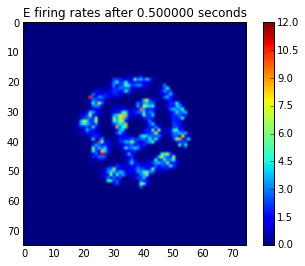

In [7]:
start_time = time.time()
[r_E, r_I, I_E, I_I] = run_simulation(dt, steps, c, h, n_E, n_I, k, tau_ex, tau_in)
end_time = time.time()

print "Elapsed simulation time: ", end_time-start_time

plt.figure()
plt.title("E firing rates after %f seconds" % (dt*steps))
plt.imshow( np.reshape(r_E[:,-1], (75, 75)) )
plt.colorbar()


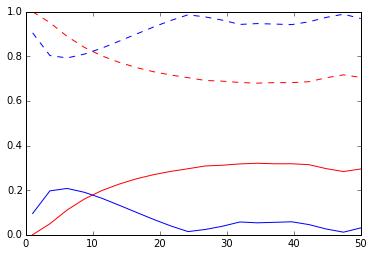

In [89]:
# run simulations for reproduction of figure 6B

stim_pref = 45
h = G(angle_diff(OP_map, stim_pref), sigma_FF) # using full-field stimuli
dt = .005
steps = 100
tau_ex = np.random.normal(.02, .05*.02, N_pairs**2)
tau_in = np.random.normal(.01, .05*.01, N_pairs**2)
k = np.random.normal(0.012, .05*.012, N_pairs**2)
n_E = np.random.normal(2.0, .05*2.0, N_pairs**2)
n_I = np.random.normal(2.2, .05*2.2, N_pairs**2)

c_range = np.linspace(1,50,20)

results_r_E = np.zeros( (len(c_range), N_pairs**2, steps+1) )
results_r_I = np.copy(results_r_E)
results_I_E = np.copy(results_r_E)
results_I_I = np.copy(results_r_E)

for i in range(len(c_range)):
    [results_r_E[i,:,:], results_r_I[i,:,:], results_I_E[i,:,:], results_I_I[i,:,:]] = run_simulation(dt, steps, c_range[i], h, n_E, n_I, k, tau_ex, tau_in)
    
# plotting for reproduction of figure 6B

ext_input = np.mean((c_range[:, np.newaxis]*np.tile(h.flatten(1), (len(c_range),1))),1)
net_I_E = np.abs(np.mean( np.abs(results_I_E[:, :, -1]), 1) - ext_input)
net_I_I = np.abs(np.mean( np.abs(results_I_I[:, :, -1]), 1) - ext_input)

plt.figure()
plt.plot(c_range, net_I_E/(net_I_E + ext_input), 'r')
plt.plot(c_range, ext_input/(net_I_E + ext_input), 'r--')
plt.plot(c_range, net_I_I/(net_I_I + ext_input), 'b')
plt.plot(c_range, ext_input/(net_I_I + ext_input), 'b--')

[65 61 72 59 61 12 14 69 15 24 51  4 61 55 57 14 10 21  5 14 10 14 41 21 74] [46 58  8 61 22 69 46 37 47 33 22 21 22 20 41 26 30 22 69 68 30 68 17 22  0]
[ 45.50943396  45.8490566   49.9245283   44.83018868  42.11320755
  45.16981132  49.58490566  42.45283019  43.47169811  40.0754717
  43.81132075  48.22641509  42.11320755  43.81132075  43.13207547
  43.47169811  42.11320755  46.52830189  45.16981132  40.0754717
  42.11320755  40.0754717   40.75471698  46.52830189  46.86792453]


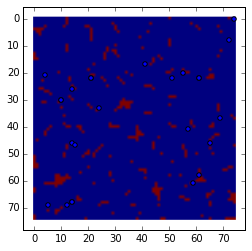

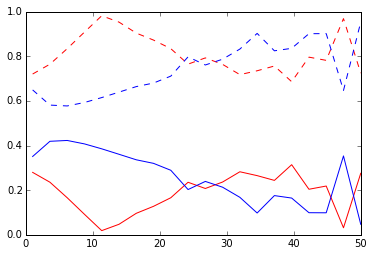

In [126]:
# plotting for reproduction of figure 6B

# ext_input = (c_range[:, np.newaxis]*np.tile(h.flatten(), (len(c_range),1)))
# # ext_input = np.sum(ext_input, 1)

# print np.where(ext_input < 0 )[0].size

# total_E = np.abs(results_I_E[:,:,-1])
# total_I = np.abs(results_I_I[:,:,-1])

# net_I_E = np.mean(np.abs(total_E - ext_input),1)
# net_I_I = np.mean(np.abs(total_I - ext_input),1)

# ext_input = np.mean(ext_input,1)

# plt.figure()
# # plt.plot(c_range, net_I_E/total_E , 'r')
# # plt.plot(c_range, ext_input/total_E, 'r--')
# # plt.plot(c_range, net_I_I/total_I, 'b')
# # plt.plot(c_range, ext_input/total_I, 'b--')
# plt.plot(c_range, net_I_E/(net_I_E+ext_input) , 'r')
# plt.plot(c_range, ext_input/(net_I_E+ext_input), 'r--')
# plt.plot(c_range, net_I_I/(net_I_I+ext_input), 'b')
# plt.plot(c_range, ext_input/(net_I_I+ext_input), 'b--')

# plt.figure()
# plt.plot(c_range, net_I_E/np.mean(total_E,1) , 'r')
# plt.plot(c_range, ext_input/np.mean(total_E,1), 'r--')
# plt.plot(c_range, net_I_I/np.mean(total_I,1), 'b')
# plt.plot(c_range, ext_input/np.mean(total_I,1), 'b--')

# ext_input = (c_range[:, np.newaxis]*np.tile(h.flatten(1), (len(c_range),1)))
# net_I_E = np.mean( np.abs( np.abs(results_I_E[:, :, -1]) - ext_input),1)
# net_I_I = np.mean( np.abs( np.abs(results_I_I[:, :, -1]) - ext_input),1)

# print results_I_E.shape

# total_E = np.sum( np.abs( results_I_E[:,:,-1] ), 1)
# total_I = np.sum( np.abs( results_I_I[:,:,-1] ), 1)

# ext_input = np.sum(ext_input,1)
# plt.figure()
# # plt.plot(c_range, net_I_E/(net_I_E + ext_input), 'r')
# plt.plot(c_range, ext_input/total_E, 'r--')
# # plt.plot(c_range, net_I_I/(net_I_I + ext_input), 'b')
# plt.plot(c_range, ext_input/total_I, 'b--')

stim_pref = 45
# Find all units with orientation preference within 10 degrees of the stimulus orientation
pref_units = np.where( np.logical_and(OP_map > stim_pref - 5, OP_map < stim_pref + 5) ) 

# randomly select 25 of those units to average over
r_units = np.floor( pref_units[0].size*np.random.rand( 25 ) )
r_units = r_units.astype(int)

unit_idx_x = pref_units[0][r_units]
unit_idx_y = pref_units[1][r_units]

print unit_idx_x, unit_idx_y

unit_idx = N_pairs*unit_idx_x + unit_idx_y

plt.figure()
plt.imshow(np.logical_and(OP_map > stim_pref - 5, OP_map < stim_pref + 5))
plt.scatter(np.array(unit_idx_x), np.array(unit_idx_y))

print OP_map[unit_idx_x, unit_idx_y]

ext_input = np.mean((c_range[:, np.newaxis]*np.tile(h.flatten(1), (len(c_range),1))),1)
net_I_E = np.abs(np.mean( np.abs(results_I_E[:, unit_idx, -1]), 1) - ext_input)
net_I_I = np.abs(np.mean( np.abs(results_I_I[:, unit_idx, -1]), 1) - ext_input)

plt.figure()
plt.plot(c_range, net_I_E/(net_I_E + ext_input), 'r')
plt.plot(c_range, ext_input/(net_I_E + ext_input), 'r--')
plt.plot(c_range, net_I_I/(net_I_I + ext_input), 'b')
plt.plot(c_range, ext_input/(net_I_I + ext_input), 'b--')

# ext_input = np.mean((c_range[:, np.newaxis]*np.tile(h.flatten(1), (len(c_range),1))),1)
# net_I_E = np.abs(np.mean( np.abs(results_I_E[:, unit_idx, -1]), 1) - ext_input)
# net_I_I = np.abs(np.mean( np.abs(results_I_I[:, unit_idx, -1]), 1) - ext_input)

# plt.figure()
# plt.plot(c_range, net_I_E/(net_I_E + ext_input), 'r')
# plt.plot(c_range, ext_input/(net_I_E + ext_input), 'r--')
# plt.plot(c_range, net_I_I/(net_I_I + ext_input), 'b')
# plt.plot(c_range, ext_input/(net_I_I + ext_input), 'b--')

# ext_input = np.mean((c_range[:, np.newaxis]*np.tile(h.flatten(1), (len(c_range),1))),1)
# net_I_E = np.abs(np.mean( results_I_E[:, :, -1], 1) - ext_input)
# net_I_I = np.abs(np.mean( results_I_I[:, :, -1], 1) - ext_input)

# plt.figure()
# plt.plot(c_range, net_I_E/(net_I_E + ext_input), 'r')
# plt.plot(c_range, ext_input/(net_I_E + ext_input), 'r--')
# plt.plot(c_range, net_I_I/(net_I_I + ext_input), 'b')
# plt.plot(c_range, ext_input/(net_I_I + ext_input), 'b--')


In [ ]:
# run simulations for reproduction of figure 6C

In [ ]:
# plotting for reproduction of figure 6C

In [ ]:
# run simulations for reproduction of figure 6E

c = 40
dt = 0.005
steps = 100
tau_ex = np.random.normal(.02, .05*.02, N_pairs**2)
tau_in = np.random.normal(.01, .05*.01, N_pairs**2)
k = np.random.normal(0.012, .05*.012, N_pairs**2)
n_E = np.random.normal(2.0, .05*2.0, N_pairs**2)
n_I = np.random.normal(2.2, .05*2.2, N_pairs**2)

size_range = np.linspace(1, 16, 10)
stimuli = np.zeros( (len(size_range), N_pairs**2) )

for i in range(len(size_range)):
    stimulusMask = np.zeros((N_pairs, N_pairs))
    stimulusMask[((posx - 8 )**2 + (posy - 8)**2)**.5 <= size_range[i]/2.] = 1.
    stimuli[i,:] =  G(angle_diff(OP_map, 45), 30) * stimulusMask
    
results_r_E = np.zeros((len(size_range), steps, N_pairs**2))
results_r_I = np.copy(results_r_E)
results_I_E = np.copy(results_r_E)
results_I_I = np.copy(results_r_E)
    
for i in range(len(size_range)):
    [results_r_E[i,:,:], results_r_I[i,:,:], results_I_E[i,:,:], results_I_I[i,:,:]] = run_simulation(dt, steps, c, stimuli[i,:], n_E, n_I, k, tau_ex, tau_in)


In [ ]:
# plotting for reproduction of figure 6E

# Find which units demonstrate SSI > 0.25:
# first, find max firing rates for stimuli shorter than 2/3 * 16 degrees:
trials = size_range[ size_range < 2./3*field_size ].size 